In [6]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [7]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/0.0_data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Grabbing dataset with keys [u'event_feature_data']


AssertionError: data must be matrix!

In [ ]:
data.dropcols("*MET*").headers

#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

['jetPTD']
data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


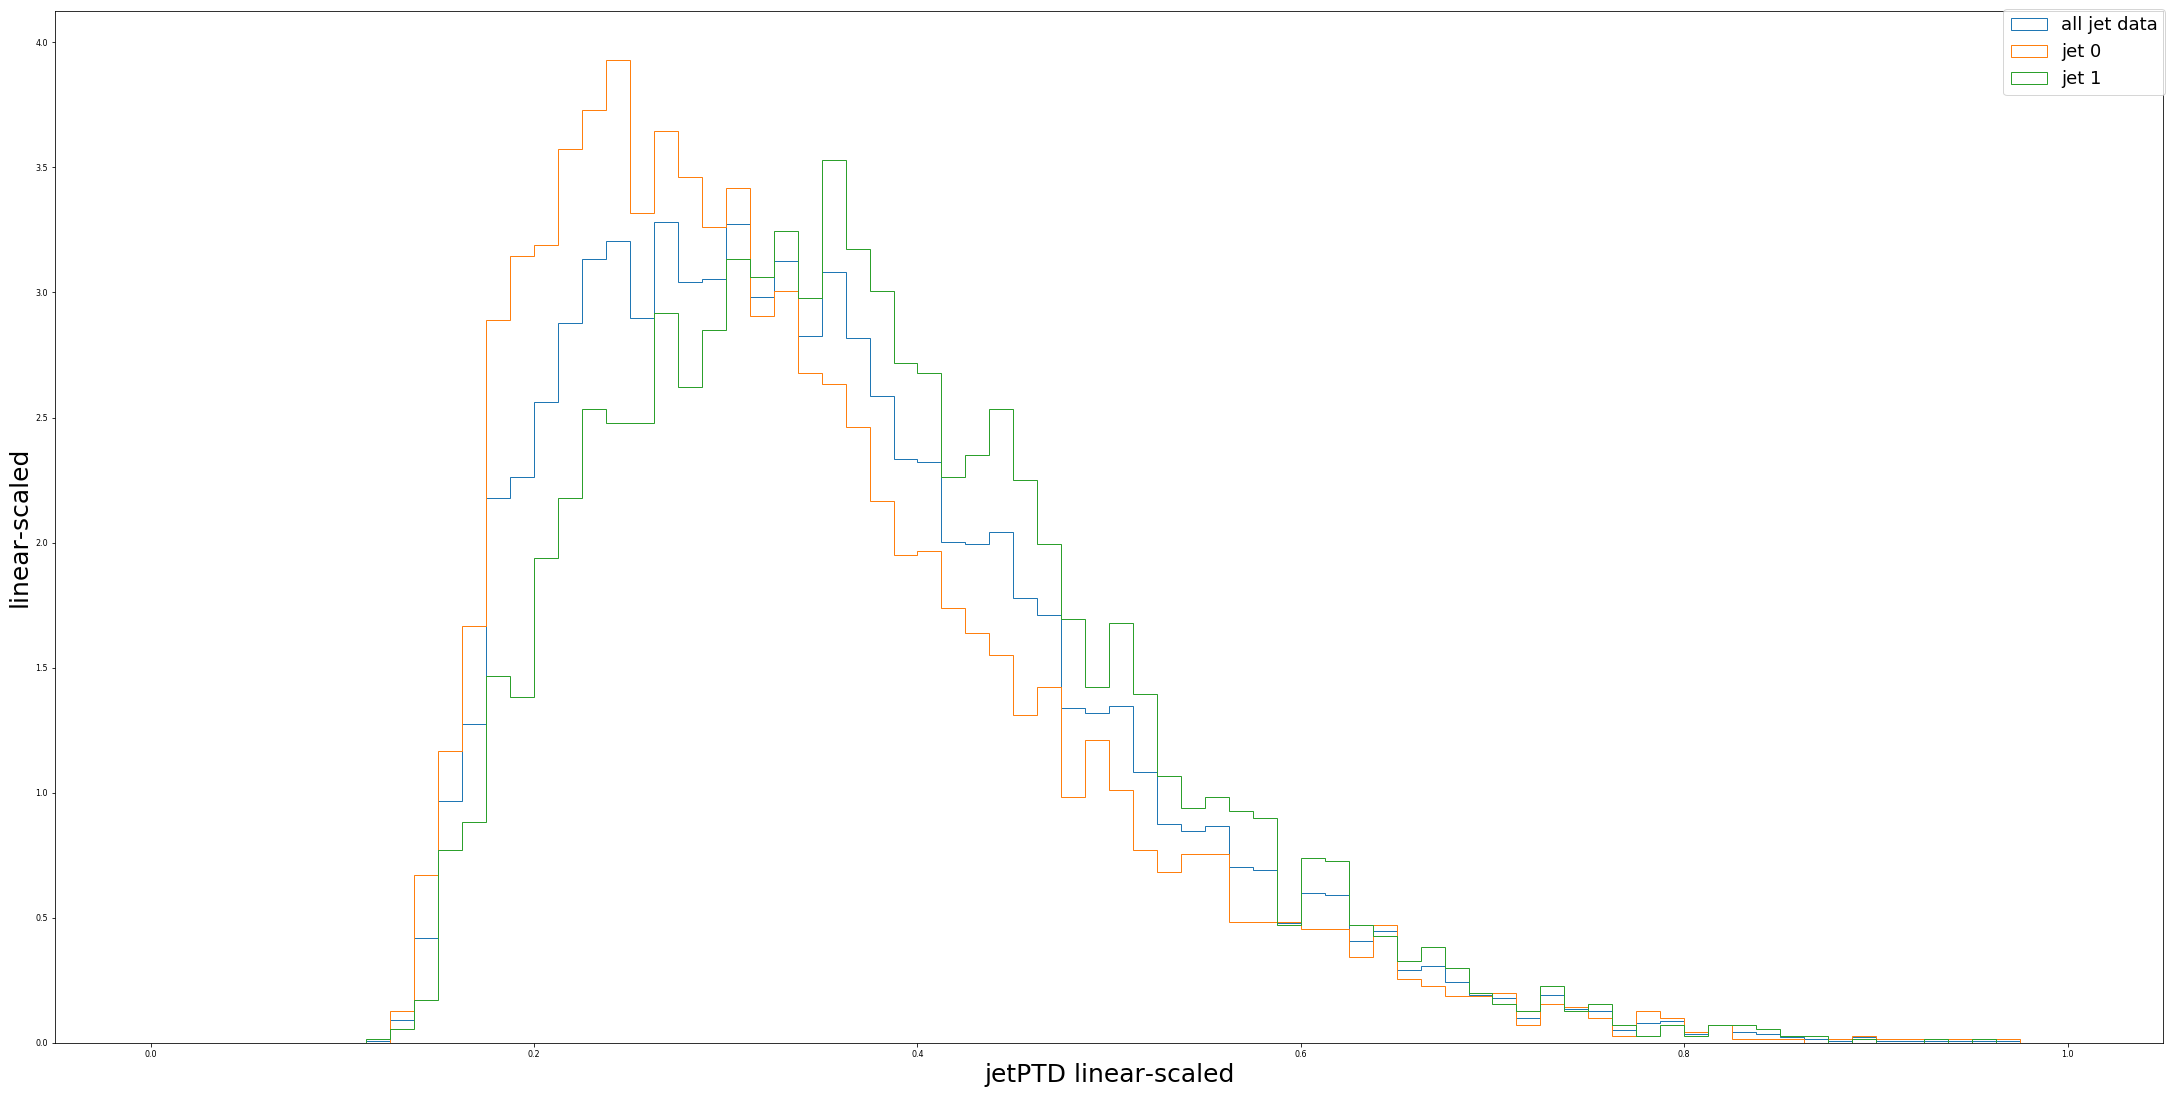

In [11]:
train, test = data.train_test_split(0.3)
# data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, values="*PTD*", normed=1, bins=80, figsize=(30,15), fontsize=25, cols=4, alpha=1, rng=(0, 1))


We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2', 'jetFlavor', 'jetEnergy', 'jetDeltaEta', 'jetDeltaPhi', 'jetMET', 'jetMETEta', 'jetMETPhi']


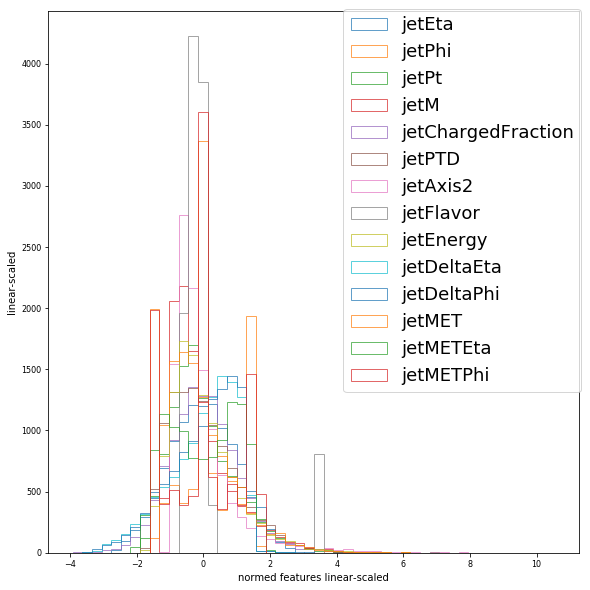

In [4]:
ntype="StandardScaler"
norm_data = data.norm(norm_type=ntype)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

norm_args = {
    "norm_type": ntype
}

# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

In [5]:
train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)
print np.vstack([train_norm.max().values, test_norm.max()]).T
print np.vstack([train_norm.min(), test_norm.min()]).T

[[  2.74170708   2.9057382 ]
 [  1.57963109   1.57957652]
 [  7.65003859   7.05945641]
 [  7.79328142   6.54614293]
 [  3.22547206   3.22547206]
 [  4.69448594   4.45266038]
 [ 10.05220997  10.55982229]
 [  3.51427948   3.51427948]
 [  6.72083772   6.59599244]
 [  2.82287973   2.82287973]
 [  3.13057004   2.62344757]
 [  8.37212817   8.37212817]
 [  2.09105007   2.09105007]
 [  1.59340051   1.59340051]]
[[-3.23110896 -2.73291417]
 [-1.5536697  -1.55362405]
 [-1.73405651 -1.73398808]
 [-1.28619795 -1.26505715]
 [-3.92788514 -3.75857491]
 [-1.74578761 -1.81286225]
 [-1.04050669 -1.04359897]
 [-0.55812533 -0.55812533]
 [-1.6577658  -1.6654414 ]
 [-3.59881641 -3.49753823]
 [-3.77245252 -3.4958385 ]
 [-1.42765964 -1.41678563]
 [-2.16489567 -1.97141603]
 [-1.56337771 -1.563325  ]]


### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [9]:
from keras import backend as K
from keras.layers import Layer, Lambda
from keras.callbacks import Callback
import numpy as np

class KSparse(Layer):
    '''k-sparse Keras layer.
    
    # Arguments
        sparsity_levels: np.ndarray, sparsity levels per epoch calculated by `calculate_sparsity_levels`
    '''
    def __init__(self, sparsity_levels, **kwargs):
        self.sparsity_levels = sparsity_levels
        self.k = K.variable(self.sparsity_levels[0], dtype=K.tf.int32)
        self.uses_learning_phase = True
        Layer.__init__(self, **kwargs)

    def call(self, inputs, mask=None):
        def sparse():
            kth_smallest = K.tf.contrib.framework.sort(inputs)[..., K.shape(inputs)[-1] - 1 - self.k]
            return inputs * K.cast(K.greater(inputs, kth_smallest[:, None]), K.floatx())
        return K.in_train_phase(sparse, inputs)

    def get_config(self):
        config = {'k': self.k}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
    

# class UpdateSparsityLevel(Callback):
#     '''Update sparsity level at the beginning of each epoch.
#     '''        
#     def on_epoch_begin(self, epoch, logs={}):
#         l = self.model.get_layer('KSparse')
#         K.set_value(l.k, l.sparsity_levels[epoch])
        
        
# def calculate_sparsity_levels(initial_sparsity, final_sparsity, n_epochs):
#     '''Calculate sparsity levels per epoch.
    
#     # Arguments
#         initial_sparsity: int
#         final_sparsity: int
#         n_epochs: int
#     '''
#     return np.hstack((np.linspace(initial_sparsity, final_sparsity, n_epochs // 2, dtype=np.int),
#                       np.repeat(final_sparsity, (n_epochs // 2) + 1)))[:n_epochs]


In [10]:
import keras.regularizers 

sparsity = 4
bn = 7
interm = 30

inputs = keras.layers.Input(shape=(7,), name="input")
encoded1 = keras.layers.Dense(interm, activation="relu", name="dense_encode")(inputs)
encoded2 = keras.layers.Dense(bn, activation="relu", name="bottleneck")(encoded1)
sparse = KSparse([sparsity])(encoded2)

# decoder_inputs = keras.layers.Input(shape=(bn,), name="decoder_inputs")

decoded1 = keras.layers.Dense(interm, activation="relu", name="dense_decode")(sparse)
decoded2 = keras.layers.Dense(7, activation="linear")(decoded1)

# encoder = keras.Model(inputs=inputs, outputs=sparse, name="encoder")
# decoder = keras.Model(inputs=decoder_inputs, outputs=decoded2, name="decoder")
autoencoder = keras.Model(inputs=inputs, outputs=decoded2, name="autoencoder")

name = "{}_{}_k-sparse".format(bn, sparsity)
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/reg", name))

NotFoundError: libforestprotos.so: cannot open shared object file: No such file or directory

... and the model summaries:

In [59]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 100)               800       
_________________________________________________________________
layer_3 (Dense)              (None, 7)                 707       
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 100)               800       
______________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [60]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [62]:
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)
for i in range(4):
    autoencoder = instance.train(
        x_train=train_norm.data,
        x_test=test_norm.data,
        y_train=train_norm.data,
        y_test=test_norm.data,
        optimizer="adam",
        loss=r_square_loss,
        epochs=2,
        model=autoencoder,
        metrics=[r_square, "mae", "mse"],
        force=True,
        batch_size=64,
        use_callbacks=True,
        learning_rate=0.001,
    )
    train_reps, test_reps = (
        utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
        utils.data_table(encoder.predict(test_norm.data), name="test_reps")
    )
    print np.sum(train_reps!=0, axis=1).value_counts()

train_shell :: using model passed as function argument
Train on 7865 samples, validate on 3371 samples
Epoch 5/6
122/122 [==============================] - 4s 36ms/step - loss: 909.1108 - r_square: 0.3597 - mean_absolute_error: 0.6104 - mean_squared_error: 0.6417 - val_loss: 82.0400 - val_r_square: 0.6339 - val_mean_absolute_error: 0.4672 - val_mean_squared_error: 0.3641
Epoch 6/6
122/122 [==============================] - 3s 21ms/step - loss: 73.6119 - r_square: 0.6500 - mean_absolute_error: 0.4644 - mean_squared_error: 0.3508 - val_loss: 10.1137 - val_r_square: 0.5925 - val_mean_absolute_error: 0.4988 - val_mean_squared_error: 0.4054
EPOCH N: 6 2
train_shell :: 
train_shell :: trained 2 epochs!
train_shell :: 
finished epoch N 6
prev [2, 2, 2]
train_shell :: model saved
7    7398
6     399
5      59
4       8
3       1
dtype: int64
train_shell :: using model passed as function argument
Train on 7865 samples, validate on 3371 samples
Epoch 7/8
122/122 [==============================] 

KeyboardInterrupt: 

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

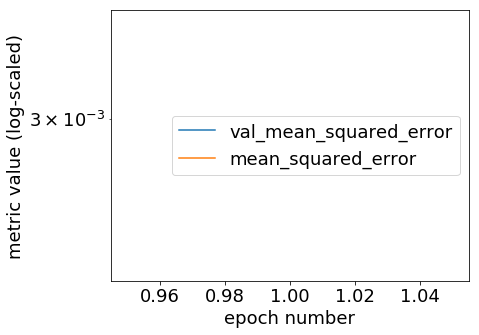

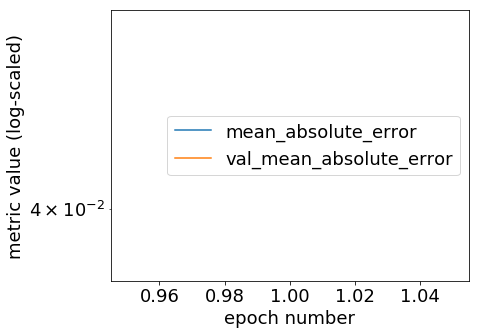

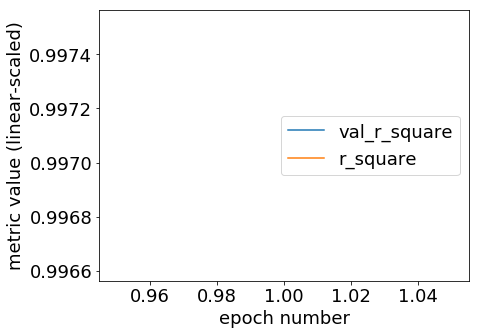

In [16]:
# instance.plot_metrics(fnmatch_criteria="*loss", yscale="log")
instance.plot_metrics(fnmatch_criteria="*mean_s*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [ ]:

data_recon_norm = utils.data_table(autoencoder.predict(data.norm(**norm_args).df.values), headers=train_norm.headers)
data_recon = data.inorm(data_recon_norm, **norm_args)
data_recon.name = "all jet data (pred)"

# train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
# test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)

# train_reconstructed = data.inorm(train_reconstructed_norm)
# # test_reconstructed = data.inorm(test_reconstructed_norm)


# train_reconstructed.name = "train reconstructed"
# test_reconstructed.name = "test reconstructed"

# train.plot([train_reconstructed], bins = 30, alpha=1.0)
# test.plot([test_reconstructed], bins=30, alpha=1.0)
data.plot(
#     [train_reconstructed, test_reconstructed],
    data_recon,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22, rng=[(-2,2), (-4,4), (0,2000), (0,210), (0,1), (0,0.8), (0, .10)]
)

data.norm(**norm_args).plot(
    data_recon_norm,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)

In [ ]:
encoder, decoder = autoencoder.layers[1:]
import pandas as pd
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)

In [ ]:
# train_reps.plot([test_reps], cols=4, figsize=(25,20), fontsize=22, normed=1, bins=50)

In [ ]:
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)
np.sum(train_reps!=0, axis=1).value_counts()

In [43]:
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

data_table :: plotting distrubution(s) for table(s) ['errors']


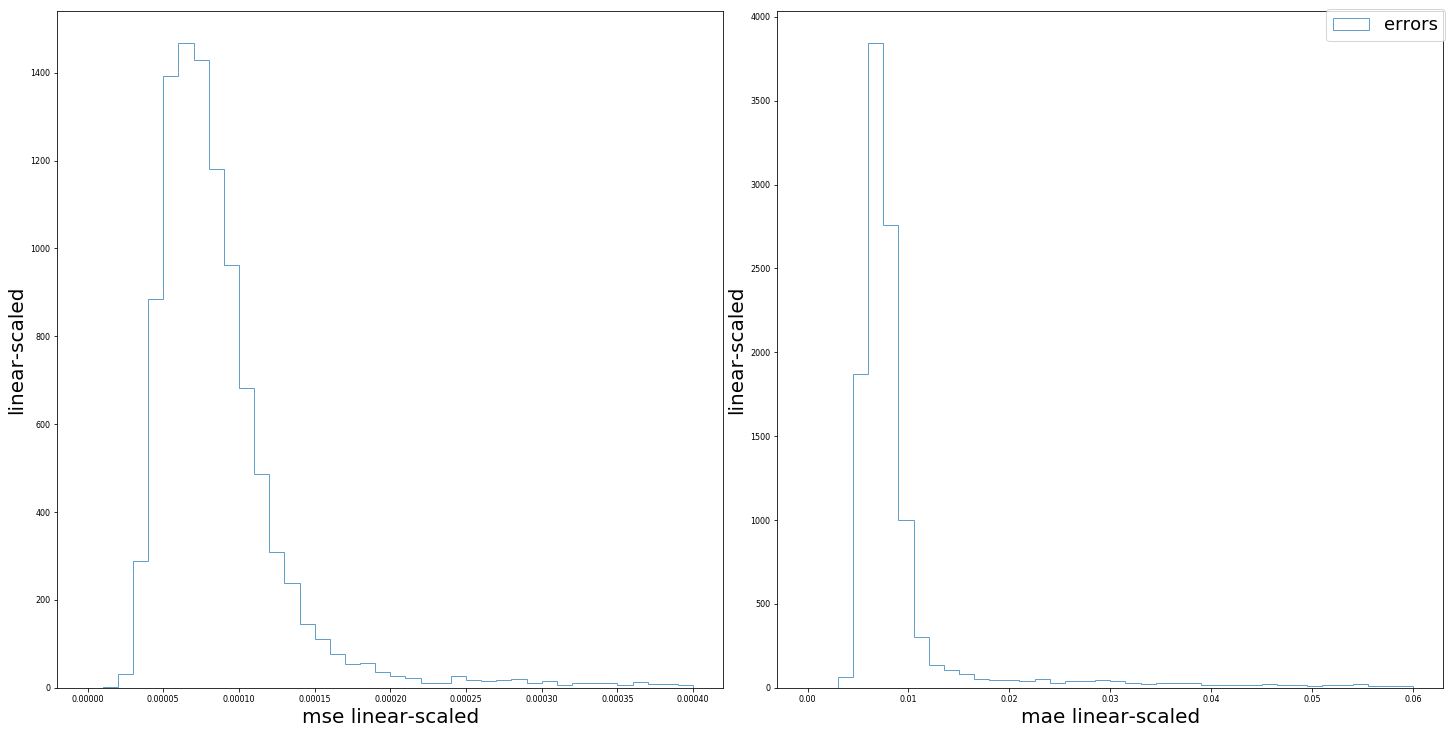

In [44]:
errors.plot(figsize=(20,10), bins=40, rng=((0,0.0004), (0, 0.06)), fontsize=20)

In [45]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['normal', 'outliers (top 0.01)']


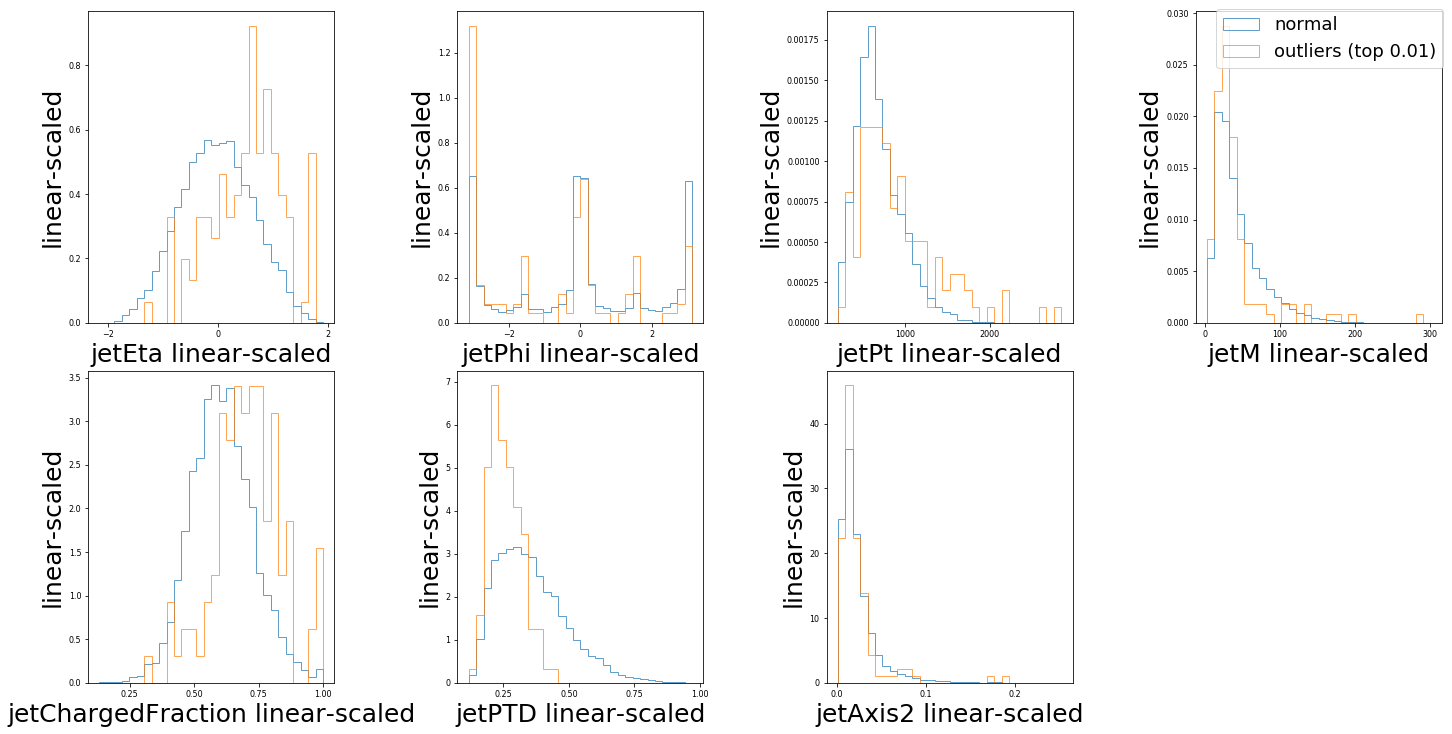

In [46]:
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
reg.plot(out, normed=1, bins=30, figsize=(20,10))

In [63]:
train_reps

,dist 1,dist 2,dist 3,dist 4,dist 5,dist 6,dist 7
0,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
1,0.197700,0.257012,0.184073,0.194582,0.214878,0.159574,0.132493
2,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
3,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
4,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
5,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
6,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
7,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
8,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
9,0.199787,0.222197,0.183904,0.206106,0.205182,0.188006,0.169519
